In [1]:
import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import zipfile

from IPython.display import JSON, HTML
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [7]:
num_sites = 4
clean_data = False

input_filename = os.path.join(
    '..',
    'data',
    'Sverepec_spolu.zip'
)

output_dir = os.path.join(
    '..',
    'nvflare-sverepec_spolu-sim',
    'data'
)

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Preprocess data and split it to FL sites

In [8]:
def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def nsplit_df(df:pd.DataFrame, splits:[float]=[0.7]) -> pd.DataFrame:
    rows = df.shape[0]
    df_splits = []
    beg = 0
    for split in splits:
        at = int(split * rows)
        df_splits.append(df[beg:at])
        beg = at
    df_splits.append(df[beg:])
    return df_splits

In [9]:
# data
logger.debug('loading data: %s' % input_filename)
df = pd.read_csv(input_filename)

label_col = df.DRUH_DR.name

if clean_data:
    # select columns
    data_cols = df.columns[df.columns.to_series().str.match(r'b\d+(_\d+)+')]
    all_cols = data_cols.append(pd.Index([label_col]))
    logger.debug('selecting columns: %s' % all_cols.values)
    df = df[all_cols]

    # drop rows having at least 1 column na
    df = df.dropna(axis=0, how='any')

    # data cleaning - keep records with defined labels
    df = df[~df.DRUH_DR.isna() & df.DRUH_DR.str.match(r'[A-Z]{2}|lieska')]

    # # replace nan in labels
    # df[label_col] = df[label_col].fillna('NaN')

# encode string labels
logger.debug('encoding labels: %s' % label_col)
label_encoder = LabelEncoder()
df[label_col] = label_encoder.fit_transform(df[label_col])

# save encoder
encoder_filename = os.path.join(output_dir, 'encoder-%s.npy' % label_col)
logger.debug('saving encoder: %s' % encoder_filename)
np.save(encoder_filename, label_encoder.classes_)
        
site_dfs = []
# randomly sample data into proportionally-sized sites and split it to train and test for each site
for i in trange(num_sites, desc='sampling site data'):

    # sample site data
    frac = 1 / (num_sites - i)
    site_df = df.sample(frac = frac)
    df = df.drop(site_df.index)

    # split site data to train and test
    site_df_train, site_df_test = split_df(site_df, split=0.7)

    site = i + 1  
    site_dir = os.path.join(output_dir, 'site-%d' % site)
    if not os.path.exists(site_dir):
        os.mkdir(site_dir)
       
    # make symlink to label encoder
    symlink = os.path.join(site_dir, os.path.basename(encoder_filename))
    if not os.path.exists(symlink):
        os.link(encoder_filename, symlink)
    
    site_df_train.to_csv(os.path.join(site_dir, 'train.csv'), index=False)
    site_df_test.to_csv(os.path.join(site_dir, 'test.csv'), index=False)

2023-03-21 00:05:15,088 | hysped | DEBUG : loading data: ../data/Sverepec_spolu.zip
2023-03-21 00:05:15,834 | hysped | DEBUG : encoding labels: DRUH_DR
2023-03-21 00:05:15,840 | hysped | DEBUG : saving encoder: ../nvflare-sverepec_spolu-sim/data/encoder-DRUH_DR.npy


sampling site data:   0%|          | 0/4 [00:00<?, ?it/s]

## Show stats on site data

  0%|          | 0/4 [00:00<?, ?it/s]

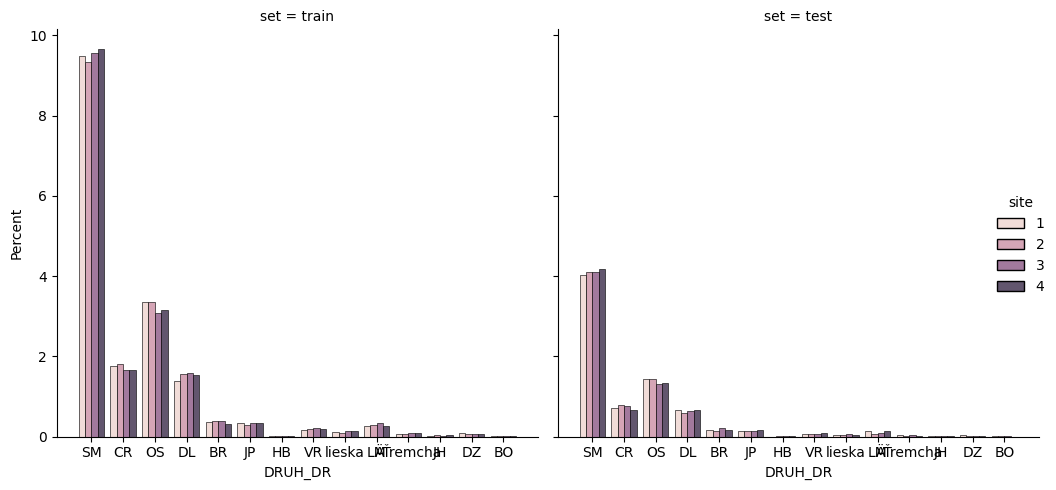

In [10]:
# load and merge site data into one dataframe
dfs = pd.DataFrame()
for site in trange(1, num_sites + 1):    
    for df_name in ['train', 'test']:
        df = pd.read_csv(os.path.join(output_dir, 'site-%d' % site, '%s.csv' % df_name))
        df['site'] = site
        df['set'] = df_name
        dfs = pd.concat([dfs, df])

# load label encoder to decode labels back
label_encoder_filename = os.path.join(output_dir, 'encoder-%s.npy' % label_col)
label_encoder = label_encoder = LabelEncoder()
label_encoder.classes_ = np.load(label_encoder_filename, allow_pickle=True)
# decode labels from numeric to string
dfs[label_col] = label_encoder.inverse_transform(dfs[label_col])

# plot stats
sns.displot(
    dfs,
    x=label_col,
    col='set',
    stat='percent',
    multiple='dodge',
    shrink=0.8,
    hue='site',
    facet_kws=dict(margin_titles=True)
)
plt.tight_layout()
plt.show()